# Tensorflow Tutorial
by Felix Kreuk.

# What is `Tensorflow`
TensorFlow is an open source software library for numerical computation using data flow graphs. We will demonstrate how to define and train neural network models for multi-class classification problems.

In this tutorial, we will train:
* Logistic Regression Model
* One-Hidden Layer Neural Network Model
* Convolutional Neural Network Model

We will train all of which on MNIST dataset.

# Computation Graph
![title](graph.png)

# Back to MNIST
The following code will import and download the MNIST dataset.

In [16]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import numpy as np
import matplotlib.pyplot as plt

# read the data and labels as ont-hot vectors
# one-hot means a sparse vector for every observation where only
# the class label is 1, and every other class is 0.
# more info here:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 10000, 5000)
((55000, 784), (55000, 10))
(0.0, 1.0)


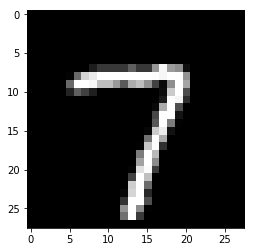

In [17]:
%matplotlib inline
# mnist is now a DataSet with accessors for:
#'train', 'test', and 'validation'.
# within each, we can access:
# images, labels, and num_examples
print(mnist.train.num_examples,
      mnist.test.num_examples,
      mnist.validation.num_examples)

# the images are stored as:
# n_observations x n_features tensor (n-dim array)
# the labels are stored as n_observations x n_labels,
# where each observation is a one-hot vector.
print(mnist.train.images.shape, mnist.train.labels.shape)

# the range of the values of the images is from 0-1
print(np.min(mnist.train.images), np.max(mnist.train.images))

# we can visualize any one of the images by reshaping it to a 28x28 image
plt.imshow(np.reshape(mnist.train.images[100, :], (28, 28)), cmap='gray')

# Logistic Regression
Logistic regression is a linear model. It solves the same problem that the perceptron algorithm solves - finding a linear seperator for our data.

Lets start by creating placeholders for our data (you can think of placeholders like variables in our computation graph).

In [18]:
n_input = 784
n_output = 10
net_input = tf.placeholder(tf.float32, [None, n_input])
y_true = tf.placeholder(tf.float32, [None, 10])

# The Model
Next, let us define our model, it's pretty basic: $y = softmax(W \cdot x + b)$.

In [19]:
W = tf.Variable(tf.truncated_normal ([n_input, n_output]))
b = tf.Variable(tf.truncated_normal ([n_output]))
net_output = tf.nn.softmax(tf.matmul(net_input, W) + b) # <-- THIS IS OUR MODEL!

# prediction and actual using the argmax as the predicted label
correct_prediction = tf.equal(tf.argmax(net_output, 1), tf.argmax(y_true, 1))

# And now we can look at the mean of our network's correct guesses
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Optimizing the Model
Now that we have our model, lets fit the data.

But first, recall we need to minimize some loss/cost function. In our case this function is called **cross-entropy** (or **negative log likelihood** for the one-hot case)

This is how to looks like:
$$
\ell(w,x,y) = - \sum_{i=0}^{n} y_i \cdot log(\hat{y_i})
$$

where $y_i$ is the true label and $\hat{y_i}$ is the model's prediction.

In [26]:
cross_entropy = -tf.reduce_sum(y_true * tf.log(net_output))

# Optimizing the Model - cont'd
To optimize, we will use a technique called **Stochastic Gradient Descent**. What it does can be see as:
* Choose an initial vector of parameters $\displaystyle{w}$ and learning rate ${\displaystyle \eta }$
* Repeat until an approximate minimum is obtained:
    * Randomly shuffle examples in the training set
    * For ${\displaystyle i=1,2,...,n}$, do:
        * $\!w_{i+1}:=w_{i}-\eta \nabla(w_{i})$.

Where $\nabla(w_{i})$ is the gradient of the loss function with respect to the parameters

In [21]:
eta = 0.01
optimizer = tf.train.GradientDescentOptimizer(eta).minimize(cross_entropy)

# Define a Session
In `tensoflow` one must use a session to communicate with the computation graph. You can ignore the technicallity for now.

Note that we also initialize our variables at this stage.
- Does the initialization process matter?

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Putting it All Together

In [23]:
batch_size = 100
n_epochs = 10
l_loss = list()
for epoch_i in range(n_epochs):
    for batch_i in range(0, mnist.train.num_examples, batch_size):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={
            net_input: batch_xs,
            y_true: batch_ys
        })
    loss = sess.run(accuracy, feed_dict={
                       net_input: mnist.validation.images,
                       y_true: mnist.validation.labels})
    print('Validation accuracy for epoch {} is: {}'.format(epoch_i + 1, loss))
    l_loss.append(loss)

Validation accuracy for epoch 1 is: 0.88639998436
Validation accuracy for epoch 2 is: 0.898400008678
Validation accuracy for epoch 3 is: 0.905200004578
Validation accuracy for epoch 4 is: 0.91060000658
Validation accuracy for epoch 5 is: 0.912800014019
Validation accuracy for epoch 6 is: 0.905799984932
Validation accuracy for epoch 7 is: 0.911800026894
Validation accuracy for epoch 8 is: 0.918799996376
Validation accuracy for epoch 9 is: 0.915000021458
Validation accuracy for epoch 10 is: 0.915799975395


# Cool. Lets See Some Results.

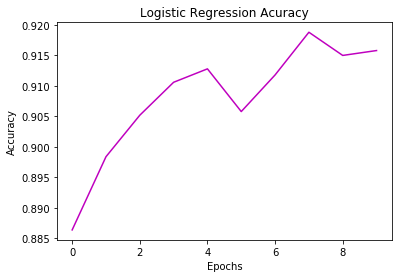

In [24]:
plt.title('Logistic Regression Acuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(l_loss, color='m')
plt.show()

# But Wait...
This is our accuracy on the validation set! What we really want to know is how we performed on the test set:

In [25]:
print("Accuracy for test set: {}". format(sess.run(accuracy,
               feed_dict={
                   net_input: mnist.test.images,
                   y_true: mnist.test.labels
               })))

Accuracy for test set: 0.91479998827


# Adding Layers
So what we have so far is a linear model, basically 1 layer.

Why not add a **hidden layer**?

Next, we will implement a model called **MLP** (Multi Layer Perceptron). It will have the following structure:
- Input layer (784)
- Hidden layer (256)
- Output layer (10)

In [28]:
n_input = 784
n_output = 10
net_input = tf.placeholder(tf.float32, [None, n_input])
y_true = tf.placeholder(tf.float32, [None, 10])

# The Model
Let us define the model, this time: $y = softmax(W2 \cdot relu(W1 \cdot x + b1) + b2)$

In [31]:
hidden_size = 256
W1 = tf.Variable(tf.truncated_normal([n_input, hidden_size]))
b1 = tf.Variable(tf.truncated_normal([hidden_size]))

W2 = tf.Variable(tf.truncated_normal([hidden_size, n_output]))
b2 = tf.Variable(tf.truncated_normal([n_output]))
net_output = (tf.matmul(tf.nn.relu(tf.matmul(net_input, W1) + b1), W2) + b2)

# prediction and actual using the argmax as the predicted label
correct_prediction = tf.equal(tf.argmax(net_output, 1), tf.argmax(y_true, 1))

# And now we can look at the mean of our network's correct guesses
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

- Why use non-linearities? (combining linear function yields a linear function)
- Other options for activation functions? (sigmoid, tanh, etc.)

# Optimizing the Model
Recall last time we defined a loss function called **cross-entropy**, this function is unstable (log is numerically unstable around zero). So this time lets use a numerically stable function already implemented for us (softmax + log + cross-entropy).

In [33]:
cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=net_output, labels=y_true))

# Optimizing the Model - cont'd
Now lets use a different optimization technique, instead of using **Stochastic Gradient Descent** let us use a method called **ADAM** (it is a varient of SGD, only with different learning rates for each dimension).

In [34]:
eta = 0.01
optimizer = tf.train.AdamOptimizer(eta).minimize(cost)

# Putting it All Together

In [35]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l_loss = list()

# train:
batch_size = 100
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(0, mnist.train.num_examples, batch_size):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={
            net_input: batch_xs,
            y_true: batch_ys
        })
    loss = sess.run(accuracy, feed_dict={
                       net_input: mnist.validation.images,
                       y_true: mnist.validation.labels })
    print('Validation accuracy for epoch {} is: {}'.format(epoch_i + 1, loss))
    l_loss.append(loss)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Validation accuracy for epoch 1 is: 0.924399971962
Validation accuracy for epoch 2 is: 0.947399973869
Validation accuracy for epoch 3 is: 0.953599989414
Validation accuracy for epoch 4 is: 0.956399977207
Validation accuracy for epoch 5 is: 0.96020001173
Validation accuracy for epoch 6 is: 0.96280002594
Validation accuracy for epoch 7 is: 0.961600005627
Validation accuracy for epoch 8 is: 0.966600000858
Validation accuracy for epoch 9 is: 0.965200006962
Validation accuracy for epoch 10 is: 0.962400019169


# Cool. Lets See Some Results

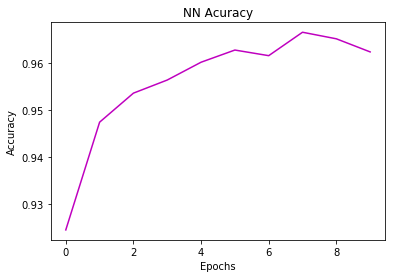

In [36]:
plt.title('NN Acuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(l_loss, color='m')
plt.show()

# Test Set

In [37]:
print("Accuracy for test set: {}".format(sess.run(accuracy,
               feed_dict={
                   net_input: mnist.test.images,
                   y_true: mnist.test.labels
               })))

Accuracy for test set: 0.957799971104


This is much better right? Recall our accuracy of ~91% with logistic regression.

# Your Turn
Now that you have seen how to build simple models it's your turn to experiment.

Train an MLP.

Your report should note:
- optimizers you have tested.
- learning rates you have tested.
- batch sizes you have tested.
- initialization methods you have tested (can you learn with zero-init?).
- architectures you have tested.
    - how many layers?
    - size of layers?
- regularization/dropout you have tested.
- type of activation functions you have tested.
- amount of epochs you have tested.
- check for overfitting (plot train and validation together).
- report you accuracy & loss on train, validation and test.